# Identify Customer Segments

In this project, I applied unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. 

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I used this information to cluster the general population into groups with similar demographic properties. Then, I examined how the people in the customers dataset fit into those created clusters. The hypothesis was that certain clusters were over-represented in the customers data, as compared to the general population; those over-represented clusters would be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
original_columns = set(azdias.columns)
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I used this file to make cleaning decisions. First of all, I assessed the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. I converted data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
non_numerical = []
for c in azdias.columns:
    if azdias[c].dtypes == 'object':
        non_numerical.append(c)
        
print(non_numerical)       

['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']


In [5]:
for c in non_numerical:
    azdias[c] = azdias[c].replace(['XX', 'X'], np.nan)

In [6]:
numerical = [ c for c in azdias.columns if c not in non_numerical]
for c in numerical:
    missing_or_unknown = feat_info[feat_info.attribute == c].missing_or_unknown.values[0]
    if missing_or_unknown != '[]': 
        nan = [int(i) for i in missing_or_unknown.strip('[]').split(',')]
        azdias[c] = azdias[c].replace(nan, np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

There are a few columns that are outliers in terms of the proportion of values that are missing. I used matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. 

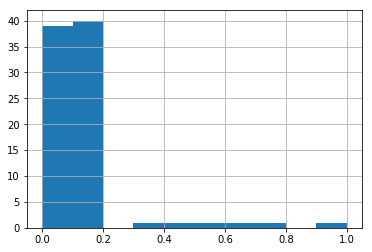

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

perc_missing = azdias.isnull().mean().sort_values(ascending = False)
perc_missing.hist(); 

In [8]:
perc_missing.head(10)

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
REGIOTYP          0.177357
KKK               0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG4       0.149597
dtype: float64

In [9]:
azdias.notnull().all().sum()

24

In [10]:
# Investigate patterns in the amount of missing data in each column.
columns_to_drop = perc_missing.index[:6]
for c in columns_to_drop:
    display(feat_info[feat_info.attribute == c])

,attribute,information_level,type,missing_or_unknown
40,TITEL_KZ,person,categorical,"[-1,0]"


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"


,attribute,information_level,type,missing_or_unknown
47,KK_KUNDENTYP,household,categorical,[-1]


,attribute,information_level,type,missing_or_unknown
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


,attribute,information_level,type,missing_or_unknown
11,GEBURTSJAHR,person,numeric,[0]


,attribute,information_level,type,missing_or_unknown
43,ALTER_HH,household,interval,[0]


In [11]:
# Remove the outlier columns from the dataset. 
# azdias =  azdias.drop(columns_to_drop, axis = 1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are 6 columns ('TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH') with more than 30% of missing information. There are 24 columns without any missing information. The rest of the columns have less than 20% of missing information. I ended up keeping those columns because the customers dataset has a different distribution of missing information. In order to keep the columns consistent between the two datasets, I did not removed those columns. 

#### Step 1.1.3: Assess Missing Data in Each Row

I performed a similar assessment for the rows of the dataset. I divided the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

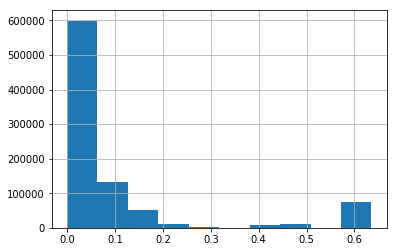

In [12]:
# How much data is missing in each row of the dataset?
perc_missing = azdias.isnull().mean(axis = 1).sort_values(ascending = False)
perc_missing.hist();

In [13]:
# Divide the data into two subsets based on the number of missing
# values in each row.

high_perc_missing = perc_missing[perc_missing > 0.35].index
low_perc_missing = perc_missing[perc_missing <= 0.35].index

In [14]:
len(high_perc_missing)/len(perc_missing)

0.1046788619208928

In [15]:
high_perc_missing = azdias.iloc[high_perc_missing]
low_perc_missing = azdias.iloc[low_perc_missing]

In [16]:
# Identify columns where there are no or few missing values
high_perc_missing.notnull().mean().sort_values(ascending = False).index[:30]

Index(['ZABEOTYP', 'GREEN_AVANTGARDE', 'SEMIO_TRADV', 'SEMIO_DOM',
       'SEMIO_KRIT', 'SEMIO_RAT', 'SEMIO_KULT', 'SEMIO_ERL', 'SEMIO_LUST',
       'SEMIO_VERT', 'SEMIO_MAT', 'SEMIO_REL', 'SEMIO_FAM', 'SEMIO_SOZ',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'FINANZ_ANLEGER', 'FINANZTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_UNAUFFAELLIGER', 'ANREDE_KZ', 'FINANZ_HAUSBAUER',
       'ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB',
       'RETOURTYP_BK_S', 'LP_STATUS_FEIN', 'CJT_GESAMTTYP'],
      dtype='object')

In [17]:
columns_low_perc_missing = ['ZABEOTYP', 'SEMIO_TRADV', 'GREEN_AVANTGARDE', 'FINANZTYP', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
       'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB']

In [18]:
def plot_dist(c):
    plt.subplot(121)
    sns.countplot(high_perc_missing[c])
    plt.title('high_perc_missing')
    plt.subplot(122)
    sns.countplot(low_perc_missing[c])
    plt.title('low_perc_missing')
    plt.show()

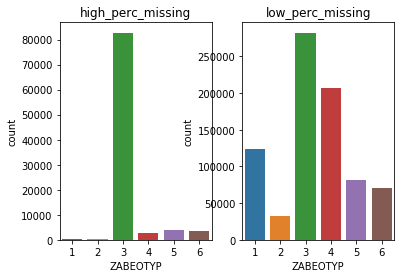

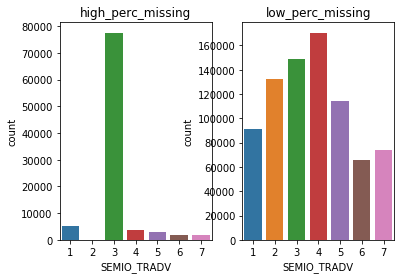

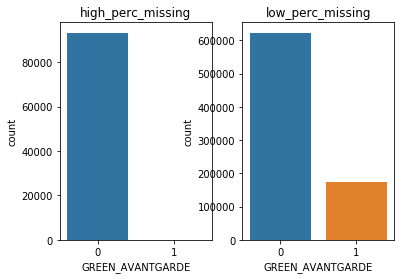

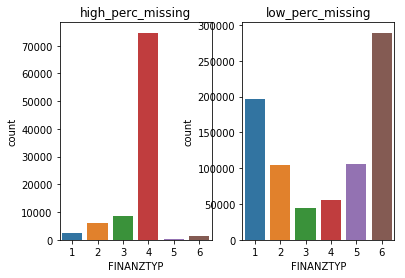

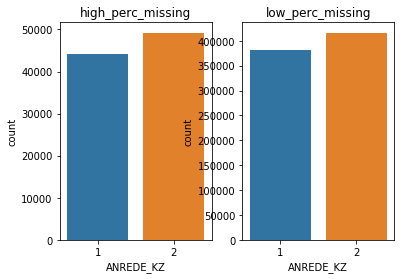

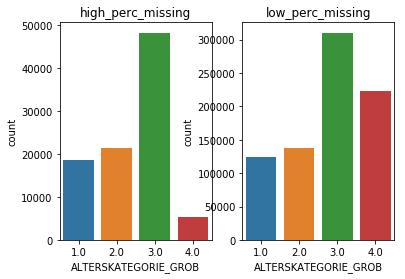

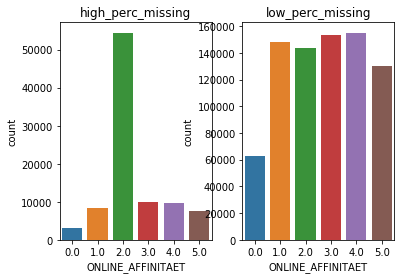

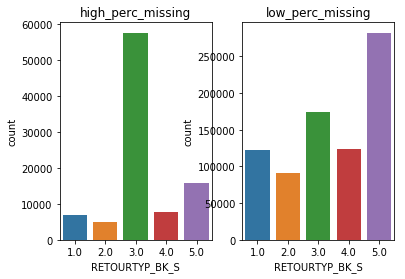

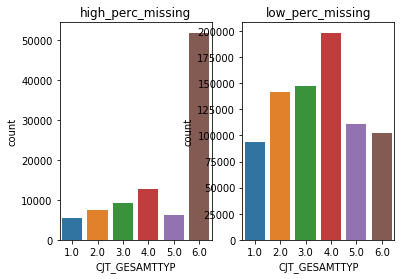

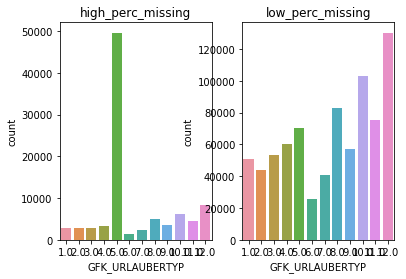

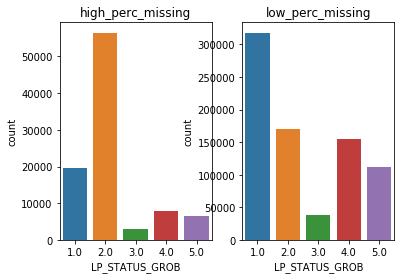

In [19]:
# Compare the distribution of values for columns where there are
# no or few missing values, between the two subsets.

for c in columns_low_perc_missing:
    plot_dist(c)

#### Discussion 1.1.3: Assess Missing Data in Each Row
 
The data with many missing values looks very different from the data with few or no missing values. As a result, I made a note on those data as special, and will revisit these data later on. 

### Step 1.2: Select and Re-Encode Features

In this step, I made a few encoding changes or additional assumptions to be able to make progress. While almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. The third column of the feature summary (`feat_info`) shows a summary of types of measurement.

- For numeric and interval data, I kept these features without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, I made the simplifying assumption that the ordinal variables could be treated as being interval in nature (that is, kept without any changes).
- The remaining two variable types: categorical, and 'mixed' needed special handling .

In [20]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I re-encoded the levels as dummy variables. 

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = [c for c in feat_info[feat_info.type == 'categorical'].attribute.values] # if c not in columns_to_drop]
levels = [len(azdias[c].value_counts()) for c in categorical]        

df = pd.DataFrame(np.array([categorical, levels]).T, columns = ['categorical', 'levels'])
df = df.set_index('categorical')
df['levels'] = df['levels'].astype(int)
df = df.sort_values('levels')


In [22]:
binary = df[df.levels == 2].index
for c in binary:
    print(azdias[c].value_counts())

# Re-encode the binary categories
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)
azdias['ANREDE_KZ'] = azdias['ANREDE_KZ'].apply(lambda x: 1 if x == 2 else 0)
azdias['VERS_TYP'] = azdias['VERS_TYP'].apply(lambda x: 1 if x == 2 else 0)

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


In [23]:
multi = df[(df.levels >2) & (df.levels <44)].index
columns_to_drop = df[df.levels >2].index

# Re-encode categorical variable(s) to be kept in the analysis.
azdias[multi] = azdias[multi].astype('str')
ohc = pd.get_dummies(azdias[multi], drop_first = True)
azdias = azdias.drop(columns_to_drop, axis = 1)
azdias = pd.concat([azdias, ohc], axis = 1)

#### Discussion 1.2.1: Re-Encode Categorical Features

I re-encoded the binary variables using 0 and 1, and re-encoded the multi-level variables with one-hot-encoder. I dropped the multi-level variables with 44 levels. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a two features that are marked as "mixed" in the feature summary that required special treatment in order to be included in the analysis. 

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). I created two new variables to capture the other two dimensions: a numeric variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
"""### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)"""
# azdias["PRAEGENDE_JUGENDJAHRE"] = azdias["PRAEGENDE_JUGENDJAHRE"].astype('float')

decade_map = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
azdias["MOVEMENT"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
azdias['DECADE'] = azdias["PRAEGENDE_JUGENDJAHRE"].map(decade_map)
azdias[["MOVEMENT",'DECADE']].head()

,MOVEMENT,DECADE
0,0,NaN
1,1,90.0
2,0,90.0
3,1,70.0
4,1,70.0


In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
"""### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown"""
azdias["CAMEO_INTL_2015"] = azdias["CAMEO_INTL_2015"].astype(float)
azdias["WEALTH"] = azdias["CAMEO_INTL_2015"].apply(lambda x: x//10)
azdias["LIEF_STAGE"] = azdias["CAMEO_INTL_2015"].apply(lambda x: x%10)
azdias[["WEALTH", "LIEF_STAGE"]].head()

,WEALTH,LIEF_STAGE
0,NaN,NaN
1,5.0,1.0
2,2.0,4.0
3,1.0,2.0
4,4.0,3.0


In [26]:
azdias = azdias.drop(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], axis =1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I splited the "PRAEGENDE_JUGENDJAHRE" column into two columns: "MOVEMENT",'DECADE'. 
I splited the "CAMEO_INTL_2015" into two columns: "WEALTH", "LIEF_STAGE". 
Then I dropped "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015". 

#### Step 1.2.3: Complete Feature Selection

In [27]:
azdias.shape

(891221, 167)

In [28]:
new_columns = set(azdias.columns)

new_columns.difference(original_columns)

{'AGER_TYP_2.0',
 'AGER_TYP_3.0',
 'AGER_TYP_nan',
 'CAMEO_DEUG_2015_2',
 'CAMEO_DEUG_2015_3',
 'CAMEO_DEUG_2015_4',
 'CAMEO_DEUG_2015_5',
 'CAMEO_DEUG_2015_6',
 'CAMEO_DEUG_2015_7',
 'CAMEO_DEUG_2015_8',
 'CAMEO_DEUG_2015_9',
 'CAMEO_DEUG_2015_nan',
 'CJT_GESAMTTYP_2.0',
 'CJT_GESAMTTYP_3.0',
 'CJT_GESAMTTYP_4.0',
 'CJT_GESAMTTYP_5.0',
 'CJT_GESAMTTYP_6.0',
 'CJT_GESAMTTYP_nan',
 'DECADE',
 'FINANZTYP_2',
 'FINANZTYP_3',
 'FINANZTYP_4',
 'FINANZTYP_5',
 'FINANZTYP_6',
 'GEBAEUDETYP_2.0',
 'GEBAEUDETYP_3.0',
 'GEBAEUDETYP_4.0',
 'GEBAEUDETYP_5.0',
 'GEBAEUDETYP_6.0',
 'GEBAEUDETYP_8.0',
 'GEBAEUDETYP_nan',
 'GFK_URLAUBERTYP_10.0',
 'GFK_URLAUBERTYP_11.0',
 'GFK_URLAUBERTYP_12.0',
 'GFK_URLAUBERTYP_2.0',
 'GFK_URLAUBERTYP_3.0',
 'GFK_URLAUBERTYP_4.0',
 'GFK_URLAUBERTYP_5.0',
 'GFK_URLAUBERTYP_6.0',
 'GFK_URLAUBERTYP_7.0',
 'GFK_URLAUBERTYP_8.0',
 'GFK_URLAUBERTYP_9.0',
 'GFK_URLAUBERTYP_nan',
 'KK_KUNDENTYP_2.0',
 'KK_KUNDENTYP_3.0',
 'KK_KUNDENTYP_4.0',
 'KK_KUNDENTYP_5.0',
 'KK_KUNDEN

### Step 1.3: Create a Cleaning Function

I created the function below to execute the main feature selection, encoding, and re-engineering steps performed above. So that I can just run this function on the DataFrame to get the trimmed dataset in a single step.

In [29]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    # Identify missing or unknown data values and convert them to NaNs.
    non_numerical = [c for c in df.columns if df[c].dtypes == 'object']
    for c in non_numerical:
        df[c] = df[c].replace(['XX', 'X'], np.nan)  

    numerical = [ c for c in df.columns if c not in non_numerical]
    for c in numerical:
        missing_or_unknown = feat_info[feat_info.attribute == c].missing_or_unknown.values[0]
        if missing_or_unknown != '[]': 
            nan = [int(i) for i in missing_or_unknown.strip('[]').split(',')]
            df[c] = df[c].replace(nan, np.nan)

    # Drop columns with more than 20% of data missing
#     perc_missing = df.isnull().mean().sort_values(ascending = False)

#     columns_to_drop = perc_missing[perc_missing > 0.2].index

#     df =  df.drop(columns_to_drop, axis = 1)

    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    categorical = [c for c in feat_info[feat_info.type == 'categorical'].attribute.values] # if c not in columns_to_drop]
    levels = [len(df[c].value_counts()) for c in categorical]        

    categorical_level_df = pd.DataFrame(np.array([categorical, levels]).T, columns = ['categorical', 'levels'])
    categorical_level_df = categorical_level_df.set_index('categorical')
    categorical_level_df['levels'] = categorical_level_df['levels'].astype(int)
    categorical_level_df = categorical_level_df.sort_values('levels')

#     binary = categorical_level_df[categorical_level_df.levels == 2].index

    # Re-encode the binary categories
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)
    df['ANREDE_KZ'] = df['ANREDE_KZ'].apply(lambda x: 1 if x == 2 else 0)
    df['VERS_TYP'] = df['VERS_TYP'].apply(lambda x: 1 if x == 2 else 0)

    multi = categorical_level_df[(categorical_level_df.levels >2) & (categorical_level_df.levels <44)].index
    columns_to_drop = categorical_level_df[categorical_level_df.levels >2].index

    # Re-encode multi-level categorical variable(s) to be kept in the analysis.
    df[multi] = df[multi].astype('str')
    ohc = pd.get_dummies(df[multi], drop_first = True)
    df = df.drop(columns_to_drop, axis = 1)
    df = pd.concat([df, ohc], axis = 1)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    decade_map = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
    df["MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: 1 if x in [1, 3, 5, 8, 10, 12, 14] else 0)
    df['DECADE'] = df["PRAEGENDE_JUGENDJAHRE"].map(decade_map)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].astype(float)
    df["WEALTH"] = df["CAMEO_INTL_2015"].apply(lambda x: x//10)
    df["LIEF_STAGE"] = df["CAMEO_INTL_2015"].apply(lambda x: x%10)
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before applying dimensionality reduction techniques to the data, i performed feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler, I removed all data points with missing data by applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html).
- For the actual scaling function, I scaled each feature to mean 0 and standard deviation 1 by applying a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [30]:
# Apply Imputer

imputer = Imputer()
imputed_azdias = imputer.fit_transform(azdias)

In [31]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaled_azdias = scaler.fit_transform(imputed_azdias)

### Discussion 2.1: Apply Feature Scaling

I used the Imputer to replace the missing values with the mean of the column, and then used the Standard Scaler to scale the data. 

### Step 2.2: Perform Dimensionality Reduction

On the scaled data, I applied dimensionality reduction techniques.

- I used sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.
- I examined the ratio of variance explained by each principal component as well as the cumulative variance explained. I also plotted the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on the plot, I selected the number of transformed features to be retained for the clustering.
- I re-fit a PCA instance to perform the decided-on transformation.

In [32]:
# Apply PCA to the data.
pca = PCA()

pca.fit_transform(scaled_azdias)

array([[  1.23558491e+00,  -2.09725287e+00,   5.72701438e+00, ...,
          1.71462751e-15,  -2.68132118e-15,   1.44832777e-15],
       [  5.03773144e+00,  -2.75624560e+00,  -2.14043427e+00, ...,
         -1.69282648e-15,   3.49986792e-16,  -6.94285892e-16],
       [  2.11034638e-01,  -7.51995749e-01,   5.80296273e-01, ...,
          8.15835395e-15,   1.12632793e-15,   5.47732304e-15],
       ..., 
       [ -3.52912618e-01,  -3.98368362e+00,   3.98083735e-01, ...,
          1.38950926e-16,  -5.24134864e-16,  -5.97550545e-17],
       [  6.40775896e+00,  -2.23783552e+00,  -4.38762339e+00, ...,
          1.77413766e-17,  -3.22828244e-17,   1.20860045e-17],
       [ -2.11313591e-01,   2.46759370e+00,  -1.16881785e+00, ...,
         -1.42492399e-17,   4.66806321e-17,  -1.16559204e-18]])

In [33]:
pca.explained_variance_ratio_.cumsum()[:66]

array([ 0.08623763,  0.15682031,  0.20873853,  0.2435088 ,  0.27497149,
        0.2999929 ,  0.32295881,  0.34032191,  0.35686797,  0.37170103,
        0.38573944,  0.39927252,  0.41255957,  0.42513252,  0.43745372,
        0.4492379 ,  0.46084855,  0.47181885,  0.48276292,  0.49275682,
        0.50201046,  0.5109419 ,  0.51980793,  0.52811324,  0.53631382,
        0.54431098,  0.55203334,  0.55961192,  0.56708808,  0.57446708,
        0.58176177,  0.58891662,  0.59599135,  0.60297875,  0.60988442,
        0.61664579,  0.62334001,  0.62997361,  0.63654772,  0.64310967,
        0.64956037,  0.65599876,  0.66240219,  0.66878199,  0.67510207,
        0.6814211 ,  0.68770206,  0.69394815,  0.70019035,  0.70637728,
        0.7125503 ,  0.7186795 ,  0.72478084,  0.7308507 ,  0.73687755,
        0.74289263,  0.74890133,  0.7549015 ,  0.76089298,  0.76688098,
        0.77286516,  0.7788397 ,  0.78479565,  0.79069397,  0.79650814,
        0.80226276])

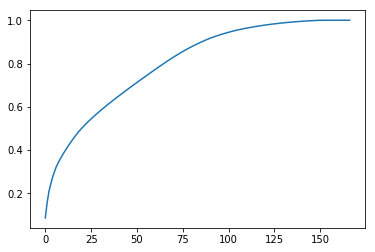

In [34]:
# Investigate the variance accounted for by each principal component.

plt.plot(pca.explained_variance_ratio_.cumsum())

In [35]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 66)
pc = pca.fit_transform(scaled_azdias)

### Discussion 2.2: Perform Dimensionality Reduction

I retained 66 principal componentsare for the next step of the analysis. They contributed to 80% of the variability. 

### Step 2.3: Interpret Principal Components

After obtaining the transformed principal components, I examined the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, I mapped each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component are those at the beginning and end of the sorted list. I used the data dictionary document to understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.

In [36]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_df = pd.DataFrame(pca.components_, columns = azdias.columns)
pca_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_nan,MOVEMENT,DECADE,WEALTH,LIEF_STAGE
0,-0.105449,0.011277,-0.196897,0.139956,-0.109503,0.079381,0.080537,0.136880,0.082031,-0.096958,...,-0.003441,-0.030789,-0.044693,0.000557,0.000518,-0.002440,0.053262,0.097653,0.175366,-0.108382
1,0.196576,0.005612,0.060064,-0.211319,0.201272,-0.212870,-0.213875,0.106580,-0.177307,-0.002239,...,-0.036715,0.016519,0.038360,0.028231,-0.061302,0.002423,0.056516,-0.213994,0.080033,-0.010195
2,0.060882,0.120203,0.009316,-0.013840,0.054931,0.070753,0.064778,0.039694,-0.076983,-0.035188,...,0.164443,-0.000398,0.011706,-0.017141,-0.042614,0.013793,-0.143603,-0.098474,-0.012593,0.028382
3,0.003342,-0.335584,0.139396,-0.029402,0.039541,-0.096844,0.023151,-0.069519,-0.054307,0.076533,...,0.084501,0.005995,0.004759,-0.003597,-0.043492,0.034402,-0.132471,-0.063645,-0.010692,0.005251
4,0.004727,0.055418,0.027183,-0.007716,0.006488,-0.056108,0.025488,-0.037757,0.010547,0.240787,...,0.007783,-0.014182,-0.013686,0.043623,0.025917,-0.017446,-0.217436,0.012136,-0.031444,0.014599


In [37]:
def feature_and_weight(pc):
    return pca_df.iloc[pc-1].sort_values(ascending = False)
feature_and_weight(1)

PLZ8_ANTG3               0.184234
PLZ8_ANTG4               0.179612
PLZ8_BAUMAX              0.176219
WEALTH                   0.175366
KBA05_BAUMAX             0.166579
ORTSGR_KLS9              0.158526
EWDICHTE                 0.156608
HH_EINKOMMEN_SCORE       0.146163
FINANZ_SPARER            0.139956
FINANZ_HAUSBAUER         0.136880
KBA05_ANTG4              0.127113
PLZ8_ANTG2               0.125480
LP_STATUS_FEIN_2.0       0.117451
ARBEIT                   0.113264
ANZ_HAUSHALTE_AKTIV      0.113249
KBA05_ANTG3              0.112148
RELAT_AB                 0.106972
CAMEO_DEUG_2015_9        0.105100
SEMIO_PFLICHT            0.104418
SEMIO_REL                0.102870
DECADE                   0.097653
AGER_TYP_nan             0.086209
SEMIO_RAT                0.085191
CAMEO_DEUG_2015_8        0.082378
ZABEOTYP_5               0.082077
GEBURTSJAHR              0.082031
FINANZ_UNAUFFAELLIGER    0.080537
FINANZ_ANLEGER           0.079381
SEMIO_TRADV              0.074565
SEMIO_MAT     

In [38]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

feature_and_weight(2)

FINANZ_VORSORGER         0.201272
ALTERSKATEGORIE_GROB     0.196576
SEMIO_ERL                0.150140
RETOURTYP_BK_S           0.145810
W_KEIT_KIND_HH           0.131538
AGER_TYP_2.0             0.126191
SEMIO_LUST               0.126131
ZABEOTYP_3               0.121076
FINANZTYP_5              0.112001
FINANZ_HAUSBAUER         0.106580
CJT_GESAMTTYP_2.0        0.099441
HH_EINKOMMEN_SCORE       0.095685
PLZ8_ANTG3               0.090851
PLZ8_ANTG4               0.087064
FINANZTYP_2              0.085817
EWDICHTE                 0.085434
ORTSGR_KLS9              0.084474
PLZ8_BAUMAX              0.083148
WEALTH                   0.080033
KBA05_BAUMAX             0.074687
FINANZTYP_6              0.068956
SHOPPER_TYP_3.0          0.066855
KBA05_ANTG4              0.065816
PLZ8_ANTG2               0.063619
ARBEIT                   0.062737
GFK_URLAUBERTYP_4.0      0.061434
ANZ_HAUSHALTE_AKTIV      0.061124
RELAT_AB                 0.060657
CAMEO_DEUG_2015_8        0.060233
FINANZ_MINIMAL

In [39]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

feature_and_weight(3)

GEBAEUDETYP_nan          0.251908
NATIONALITAET_KZ_nan     0.249814
SHOPPER_TYP_nan          0.247230
CAMEO_DEUG_2015_nan      0.245347
LP_FAMILIE_GROB_nan      0.207468
LP_FAMILIE_FEIN_nan      0.207468
SEMIO_KRIT               0.202521
ZABEOTYP_3               0.201141
LP_STATUS_FEIN_5.0       0.190616
FINANZTYP_4              0.182313
SEMIO_KAEM               0.176743
GFK_URLAUBERTYP_5.0      0.164443
SEMIO_DOM                0.148269
CJT_GESAMTTYP_6.0        0.127002
LP_STATUS_GROB_2.0       0.125019
ANREDE_KZ                0.120203
KK_KUNDENTYP_nan         0.114081
SEMIO_LUST               0.103267
FINANZ_ANLEGER           0.070753
SEMIO_ERL                0.065315
FINANZ_UNAUFFAELLIGER    0.064778
ALTERSKATEGORIE_GROB     0.060882
FINANZ_VORSORGER         0.054931
W_KEIT_KIND_HH           0.052931
FINANZ_HAUSBAUER         0.039694
CJT_GESAMTTYP_2.0        0.035700
RETOURTYP_BK_S           0.034104
FINANZTYP_2              0.029733
LIEF_STAGE               0.028382
WOHNDAUER_2008

### Discussion 2.3: Interpret Principal Components

Each principal component has one dimension. Within that dimention, the sign (positive or negative) of each variable's weight shows the direction that varialbe is going.  

For principal component 1, the variables with important roles in explaining the variation on the dimention include 
those with the highest positive weights (PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, WEALTH, KBA05_BAUMAX) and those with the lowest negative weights (PLZ8_ANTG1, KBA05_ANTG1 FINANZ_MINIMALIST, MOBI_REGIO). The variables in the middle have smaller roles in explaining the variation. As the weights getting closer to zero, the variables do not play any role in explaining the variation. PLZ8_ANTG3 and PLZ8_ANTG1 have almost perfect contrast, one with the weight close to 0.18 and the other with the weight close to -0.18. Finally, the principle component scores derived from this principle component will show that individuals with negative principle component scores will tend to have greater values of PLZ8_ANTG1, KBA05_ANTG1 FINANZ_MINIMALIST, and MOBI_REGIO, and lower values for the remaining Vars. While individuals with principle component scores greater than 0 will tend to have greater values of PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_BAUMAX, WEALTH, and KBA05_BAUMAX, and lower of the remaining.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

In this substep, I applied k-means clustering to the dataset and used the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- I used sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- I then computed the average difference from each point to its assigned cluster's center for a number of different cluster counts. 
- After selecting a final number of clusters to use, I re-fit a KMeans instance to perform the clustering operation. 

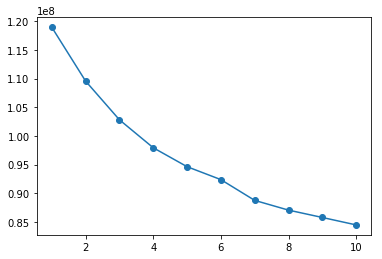

In [40]:
# Investigate the change in within-cluster distance across number of clusters.
ks = range(1, 11)
inertias = []
for k in ks:
    # Initialize the KMeans object using the current number of clusters (k)
    km = KMeans(n_clusters=k, random_state=0)
    # Fit the scaled features to the KMeans object
    km.fit(pc)
    # Append the inertia for `km` to the list of inertias
    inertias.append(km.inertia_)
    
# Plot the results in a line plot
plt.plot(ks, inertias, marker='o')

In [41]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

km = KMeans(random_state = 0, n_clusters = 7)   

### Discussion 3.1: Apply Clustering to General Population

I decided to segment the population into 7 clusters based on the elbow plot. 

### Step 3.2: Apply All Steps to the Customer Data

After obtaining the clusters and cluster centers for the general population, I examined how the customer data maps on to those clusters. 

In [42]:
# Load in the the general population data 
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [43]:
# Clean the general population data
azdias_clean = clean_data(azdias)

# Clean the customer demographics data
customers_clean = clean_data(customers)

In [44]:
# Compare the columns of the general population and the customer demographics data
old = set(azdias_clean.columns)
new = set(customers_clean.columns)
columns_to_drop = list(old.difference(new))

# Drop the columns that are not consistent between the two
azdias_clean = azdias_clean.drop(columns_to_drop, axis = 1)
columns_to_drop

['GEBAEUDETYP_5.0', 'TITEL_KZ_2.0']

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Build the preprocessing and training pipeline
pipe = Pipeline([
        ('imputer', Imputer()), 
        ('scaler', StandardScaler())]
)

# Preprocssing the general population data
azdias_transformed = pipe.fit_transform(azdias_clean)

# Preprocessing the customer demographics data
customer_transformed = pipe.transform(customers_clean)

In [46]:
# Instantiate PCA
pca = PCA(n_components = 66, random_state = 0)

# Dimentionality reduction for the general population data
azdias_pc = pca.fit_transform(azdias_transformed)

# Dimentionality reduction for the customer demographics data
customer_pc = pca.transform(customer_transformed)

In [47]:
# Instantiate KMeans
km = KMeans(n_clusters = 7, random_state=0)

# Clustering for the general population data
azdias_km = km.fit_transform(azdias_transformed)
demographic_clusters = km.labels_

# Predict the clustering for the customer demographics data
customer_clusters_prediction = km.predict(customer_transformed)

### Step 3.3: Compare Customer Data to Demographics Data

I clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters in the previous steps. In this final substep, I compared the two cluster distributions to see where the strongest customer base for the company is.

I considered the proportion of persons in each cluster for the general population, and the proportions for the customers. If the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, there would be a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid), it suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

- I computed the proportion of data points in each cluster for the general population and the customer data, and visualized it. 
- I then performed an investigation for the overrepresented and underrepresented clusters.

In [48]:
# Create a function to plot the proportion of data in each cluster 

def plot_percent(data, label):
    df = pd.DataFrame(dict(cluster=data))
    ax = sns.barplot(x="cluster", y="cluster", data=df, estimator=lambda x: len(x) / len(df) * 100)
    ax.set(ylabel="Percent")
    plt.title(f'The number of individuals in each cluster from the {label} data')

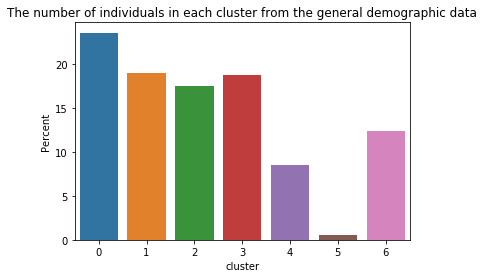

In [49]:
# plot the proportion of data in each cluster for the general population
plot_percent(demographic_clusters, 'general demographic')

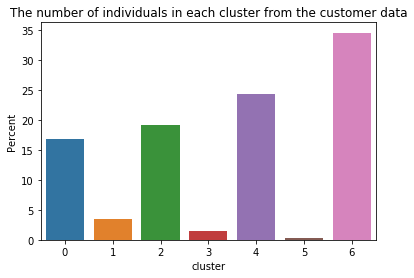

In [50]:
# plot the proportion of data in each cluster for the customer data
plot_percent(customer_clusters_prediction, 'customer')

In [51]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
index = np.where(demographic_clusters == 6)
cluster_6 = azdias.iloc[index]

In [52]:
# Age group
"""Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed
"""
print('Age group of cluster 6 \n', \
      cluster_6['ALTERSKATEGORIE_GROB'].value_counts(normalize = True))
print(' ')
print('Age group of all the clusters \n', \
      azdias['ALTERSKATEGORIE_GROB'].value_counts(normalize = True))

Age group of cluster 6 
 3.0    0.479394
4.0    0.428323
2.0    0.067581
1.0    0.024702
Name: ALTERSKATEGORIE_GROB, dtype: float64
 
Age group of all the clusters 
 3.0    0.403599
4.0    0.257233
2.0    0.178321
1.0    0.160847
Name: ALTERSKATEGORIE_GROB, dtype: float64


In [53]:
# Preferred information and buying channels group
"""Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour
"""
print('Preferred information and buying channels group of cluster 6 \n', \
      cluster_6['CJT_GESAMTTYP'].value_counts(normalize = True))
print(' ')
print('Preferred information and buying channels group of all the clusters \n', \
      azdias['CJT_GESAMTTYP'].value_counts(normalize = True))

Preferred information and buying channels group of cluster 6 
 2.0    0.247539
4.0    0.196452
3.0    0.174752
1.0    0.131271
6.0    0.129006
5.0    0.120981
Name: CJT_GESAMTTYP, dtype: float64
 
Preferred information and buying channels group of all the clusters 
 4.0    0.236712
3.0    0.175545
6.0    0.172701
2.0    0.166956
5.0    0.131702
1.0    0.110937
nan    0.005446
Name: CJT_GESAMTTYP, dtype: float64


In [54]:
# Preferred information and buying channels group
"""Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)
"""
print('Financial type of cluster 6 \n', \
      cluster_6['FINANZTYP'].value_counts(normalize = True))
print(' ')
print('Financial type of all the clusters \n', \
      azdias['FINANZTYP'].value_counts(normalize = True))


Financial type of cluster 6 
 6    0.395888
2    0.270621
5    0.218779
3    0.084742
4    0.022819
1    0.007151
Name: FINANZTYP, dtype: float64
 
Financial type of all the clusters 
 6    0.325808
1    0.223931
4    0.146569
2    0.124399
5    0.119427
3    0.059866
Name: FINANZTYP, dtype: float64


In [55]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

index = np.where(demographic_clusters == 1)
cluster_1 = azdias.iloc[index]

In [56]:
# Age group
"""Estimated age based on given name analysis
- -1: unknown (missing)
-  0: unknown (cannot be determined)
-  1: < 30 years old
-  2: 30 - 45 years old
-  3: 46 - 60 years old
-  4: > 60 years old
-  9: uniformly distributed
"""
print('Age group of cluster 1 \n', \
      cluster_1['ALTERSKATEGORIE_GROB'].value_counts(normalize = True))
print(' ')
print('Age group of all the clusters \n', \
      azdias['ALTERSKATEGORIE_GROB'].value_counts(normalize = True))

Age group of cluster 1 
 2.0    0.362478
1.0    0.345276
3.0    0.261765
4.0    0.030481
Name: ALTERSKATEGORIE_GROB, dtype: float64
 
Age group of all the clusters 
 3.0    0.403599
4.0    0.257233
2.0    0.178321
1.0    0.160847
Name: ALTERSKATEGORIE_GROB, dtype: float64


In [57]:
# Preferred information and buying channels group
"""Customer-Journey-Typology: preferred information and buying channels for
consumer
- 0: unknown
- 1: Advertising- and Consumptionminimalist
- 2: Advertising- and Consumptiontraditionalist
- 3: advertisinginterested Store-shopper
- 4: advertisinginterested Online-shopper
- 5: Advertising- and Cross-Channel-Enthusiast
- 6: Advertising-Enthusiast with restricted Cross-Channel-Behaviour
"""
print('Preferred information and buying channels group of cluster 1 \n', \
      cluster_1['CJT_GESAMTTYP'].value_counts(normalize = True))
print(' ')
print('Preferred information and buying channels group of all the clusters \n', \
      azdias['CJT_GESAMTTYP'].value_counts(normalize = True))

Preferred information and buying channels group of cluster 1 
 4.0    0.347723
6.0    0.202347
3.0    0.192239
5.0    0.169929
1.0    0.062184
2.0    0.025577
Name: CJT_GESAMTTYP, dtype: float64
 
Preferred information and buying channels group of all the clusters 
 4.0    0.236712
3.0    0.175545
6.0    0.172701
2.0    0.166956
5.0    0.131702
1.0    0.110937
nan    0.005446
Name: CJT_GESAMTTYP, dtype: float64


In [58]:
# Preferred information and buying channels group
"""Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)
"""
print('Financial type of cluster 1 \n', \
      cluster_1['FINANZTYP'].value_counts(normalize = True))
print(' ')
print('Financial type of all the clusters \n', \
      azdias['FINANZTYP'].value_counts(normalize = True))


Financial type of cluster 1 
 1    0.376827
3    0.216698
4    0.206146
6    0.179066
5    0.011191
2    0.010072
Name: FINANZTYP, dtype: float64
 
Financial type of all the clusters 
 6    0.325808
1    0.223931
4    0.146569
2    0.124399
5    0.119427
3    0.059866
Name: FINANZTYP, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

The segments of the population that are relatively popular with the mail-order company are older, consumptiontraditionalist and money-savers. The segments of the population that are relatively unpopular with the mail-order company are younger, interested in online shopping and have lower financial interest. 